In [1]:
import psycopg2
import psycopg2.extras
import getpass
import pandas

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from astropy.time import Time

from copy import deepcopy
import time

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")
db.autocommit = True
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  decat_ro
DB Password:  ········


In [3]:
tag = "latest"
db.rollback()
q = ( "SELECT id, tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']
print(tagid)

1


In [4]:
%%time
q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, "
     "i.filter, i.meanmjd, o.candidate_id, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt "
     "ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE ((od.ra > 147.0 AND od.ra < 153.0 AND od.dec > -0.25 AND od.dec < 5) "
     "OR (od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41)) ")
cursor.execute(q, {'tagid': tagid})
df = pandas.DataFrame(cursor.fetchall())
print(len(df))

3828261
CPU times: user 27.7 s, sys: 2.55 s, total: 30.2 s
Wall time: 45.7 s


In [5]:
raw_obj_ra     = np.asarray(df[0], dtype='float')
raw_obj_dec    = np.asarray(df[1], dtype='float')
raw_obj_mag    = np.asarray(df[2], dtype='float')
raw_obj_mage   = np.asarray(df[3], dtype='float')
raw_obj_rb     = np.asarray(df[4], dtype='float')
raw_obj_filt   = np.asarray(df[5], dtype='str')
raw_obj_mjd    = np.asarray(df[6], dtype='float')
raw_obj_candid = np.asarray(df[7], dtype='str')
raw_obj_propid = np.asarray(df[8], dtype='str')
del df

In [6]:
semesters = ['21A', '21B', '22A', '22B', '23A']
sem_dates_isot = ['2021-02-01T00:00:00',
                  '2021-08-01T00:00:00',
                  '2022-02-01T00:00:00',
                  '2022-08-01T00:00:00',
                       '2023-02-01T00:00:00',
             '2023-08-01T00:00:00']
sem_dates = Time(sem_dates_isot, format='isot', scale='utc')

In [9]:
# tx1 = np.where((raw_obj_mag > 20.0) & (raw_obj_mag < 20.5) & (raw_obj_rb > 0.1))[0]
# tx2 = np.where((raw_obj_mag > 20.5) & (raw_obj_mag < 21.0) & (raw_obj_rb > 0.1))[0]
# tx3 = np.where((raw_obj_mag > 21.0) & (raw_obj_mag < 21.5) & (raw_obj_rb > 0.1))[0]
tx4 = np.where((raw_obj_mag > 21.5) & (raw_obj_mag < 22.0) & (raw_obj_rb > 0.1))[0]

print(len(tx4))

185492


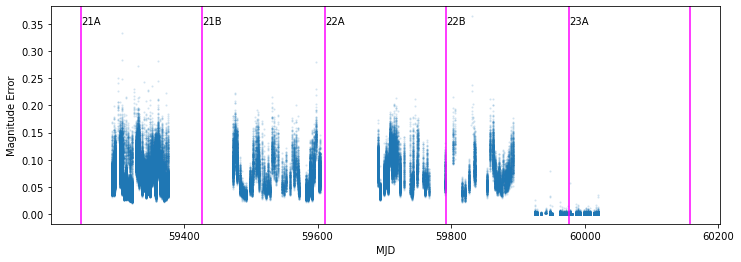

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(raw_obj_mjd[tx4], raw_obj_mage[tx4], 'o', ms=2, alpha=0.2, mew=0)
for x in [0, 1, 2, 3, 4, 5]:
    plt.axvline(sem_dates[x].mjd, color='magenta')
for x in [0, 1, 2, 3, 4]:    
    plt.text(sem_dates[x].mjd, 0.35, semesters[x])
plt.ylabel('Magnitude Error')
plt.xlabel('MJD')
plt.show()

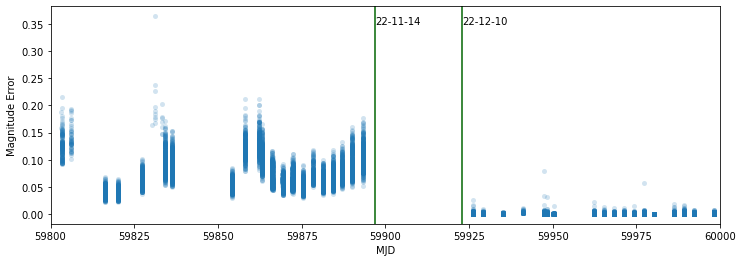

In [26]:
plt.figure(figsize=(12, 4))
plt.plot(raw_obj_mjd[tx4], raw_obj_mage[tx4], 'o', ms=5, alpha=0.2, mew=0)
# for x in [0, 1, 2, 3, 4, 5]:
#     plt.axvline(sem_dates[x].mjd, color='magenta')
# for x in [0, 1, 2, 3, 4]:    
#     plt.text(sem_dates[x].mjd, 0.35, semesters[x])

date = Time('2022-11-14T00:00:00', format='isot', scale='utc')
plt.axvline(date.mjd, color='darkgreen')
plt.text(date.mjd, 0.35, '22-11-14')
date = Time('2022-12-10T00:00:00', format='isot', scale='utc')
plt.axvline(date.mjd, color='darkgreen')
plt.text(date.mjd, 0.35, '22-12-10')

plt.ylabel('Magnitude Error')
plt.xlabel('MJD')
plt.xlim([59800,60000])
plt.show()    